# Double pendulum  (parts a and b)

## Euler-Lagrange equation

For a simple pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi} = \frac{\partial\mathcal L}{\partial\phi}
 \quad\Longrightarrow\quad
 m L^2 \ddot \phi = -mgL\sin\phi
  \ \mbox{or}\ \ddot\phi = - \omega_0^2\sin\phi = 0
  \;.
\end{align}$

## Hamilton's equations

The generalized momentum corresponding to $\phi$ is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the first simple pendulum
    L2 : float
        length of the second simple pendulum
    g : float
        gravitational acceleration at the earth's surface
    mass1 : float
        mass of first pendulum
    mass2 : float
        mass of second pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., g=1., mass1=1., mass2=1.):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.mass1 = mass1
        self.mass2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi1(t) and y[1] = dphi1/dt, y[2] = phi2(t) and y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        phi1, z1, phi2, z2 = y
        
        c, s = np.cos(phi1 - phi2), np.sin(phi1 - phi2)
        denom = (self.mass1 + self.mass2 * s**2)
        
        phi1_dot = z1
        z1_dot = (self.mass2 * self.g * np.sin(phi2) * c - self.mass2 * s * (self.L1 * z1**2 * c \
                  + self.L2 * z2**2) - (self.mass1 + self.mass2) * self.g * np.sin(phi1)) / self.L1 / denom
        phi2_dot = z2
        z2_dot = ((self.mass1 + self.mass2) * (self.L1 * z1**2 * s - self.g * np.sin(phi2) + self.g \
                  * np.sin(phi1) * c) + self.mass2 * self.L2 * z2**2 * s * c) / self.L2 / denom
        
        return phi1_dot, z1_dot, phi2_dot, z2_dot
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot, = solution.y

        return phi1, phi1_dot, phi2, phi2_dot,
    
    def E(y):
        """The total energy of the system."""
        
        p1, p1d, p2, p2d = y.T
        V = -(mass1+mass2)*L1*g*np.cos(p1) - mass2*L2*g*np.cos(p2)
        T = .5*mass1*(L1*p1d)**2 + .5*mass2*((L1*p1d)**2 + (L2*p2d)**2 + 2*L1*L2*p1d*p2d*cos(p1-p2))
        return T + V

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2)


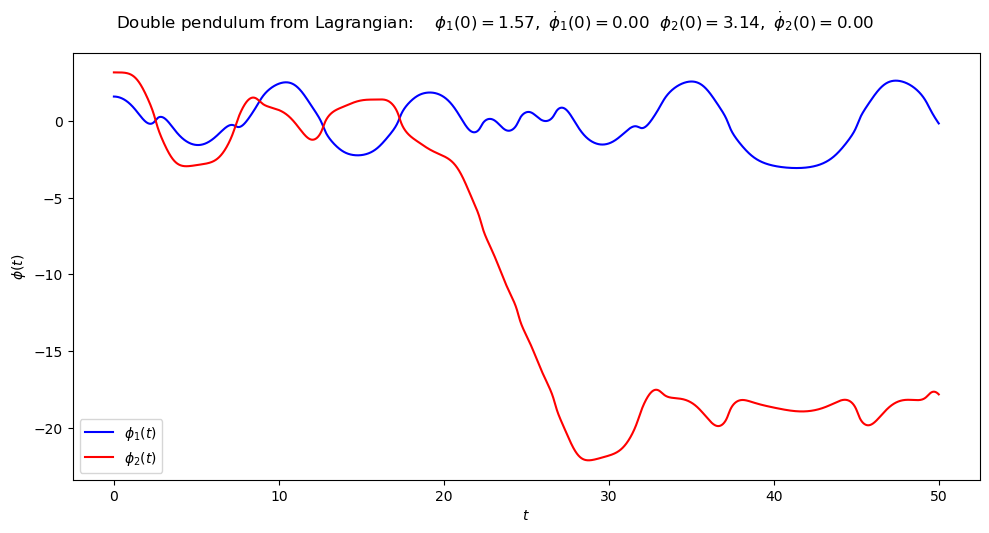

In [8]:
# both plots: same initial conditions
phi1_0 = np.pi/2
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue', 
            label=r'$\phi_1(t)$', 
            ax=ax_a)    
  
plot_y_vs_x(t_pts[start : stop], phi2[start : stop],  
            color='red', 
            label=r'$\phi_2(t)$', 
            ax=ax_a)     

fig.tight_layout()  

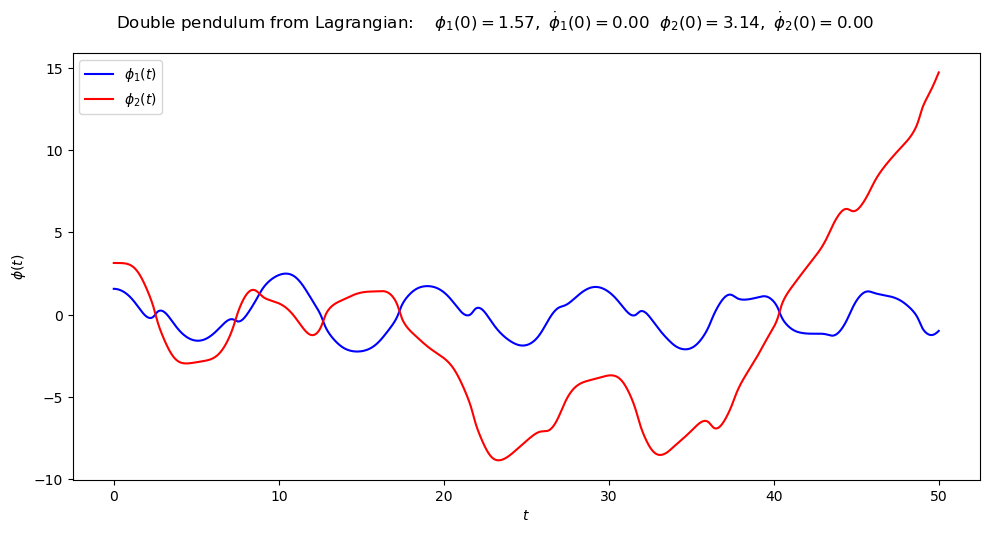

In [9]:
# We can see this system is chaotic if we change the initial condidtions slightly

phi1_0 = np.pi/2 + .0001
phi1_dot_0 = 0.
phi2_0 = np.pi + .0001
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue', 
            label=r'$\phi_1(t)$', 
            ax=ax_a)    
  
plot_y_vs_x(t_pts[start : stop], phi2[start : stop],  
            color='red', 
            label=r'$\phi_2(t)$', 
            ax=ax_a)     

fig.tight_layout()  